In [3]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import gala.potential as gp
import h5py
import numpy as np
from gala.units import galactic
import jax.numpy as jnp
from scipy.stats import binned_statistic
import torusimaging as oti
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
    plot_orbit_shapes,
)
from torusimaging_helpers.config import gala_pot, agama_pot, R0, vc0
import agama

jax.config.update("jax_enable_x64", True)

In [4]:
name = "gaia-spiral"

pdata_file = pathlib.Path(f"../.cache/{name}-pdata.hdf5")
bdata_file = pathlib.Path(f"../.cache/{name}-bdata.hdf5")

In [5]:
with h5py.File(pdata_file, "r") as f:
    Rgs = np.sort(np.array([float(f[k].attrs["Rg"]) for k in f.keys()]) * u.kpc)
Rgs

<Quantity [ 6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
           11. ] kpc>

In [6]:
def get_bin(i):
    with open(f"../.cache/{name}-{i}-model.pkl", "rb") as f:
        model = pickle.load(f)

    with open(f"../.cache/{name}-{i}-params-opt.pkl", "rb") as f:
        res_params = pickle.load(f)

    with h5py.File(pdata_file, "r") as pf:
        pdata = at.QTable.read(
            pf[str(i)],
        )

    with h5py.File(bdata_file, "r") as bf:
        group = bf[str(i)]
        bdata = {k: group[k][:] for k in group.keys()}

    # TODO: fix this!
    if not hasattr(bdata["pos"], "unit"):
        bdata["pos"] = bdata["pos"] * u.kpc
        bdata["vel"] = bdata["vel"] * u.kpc / u.Myr

    return model, res_params, bdata, pdata

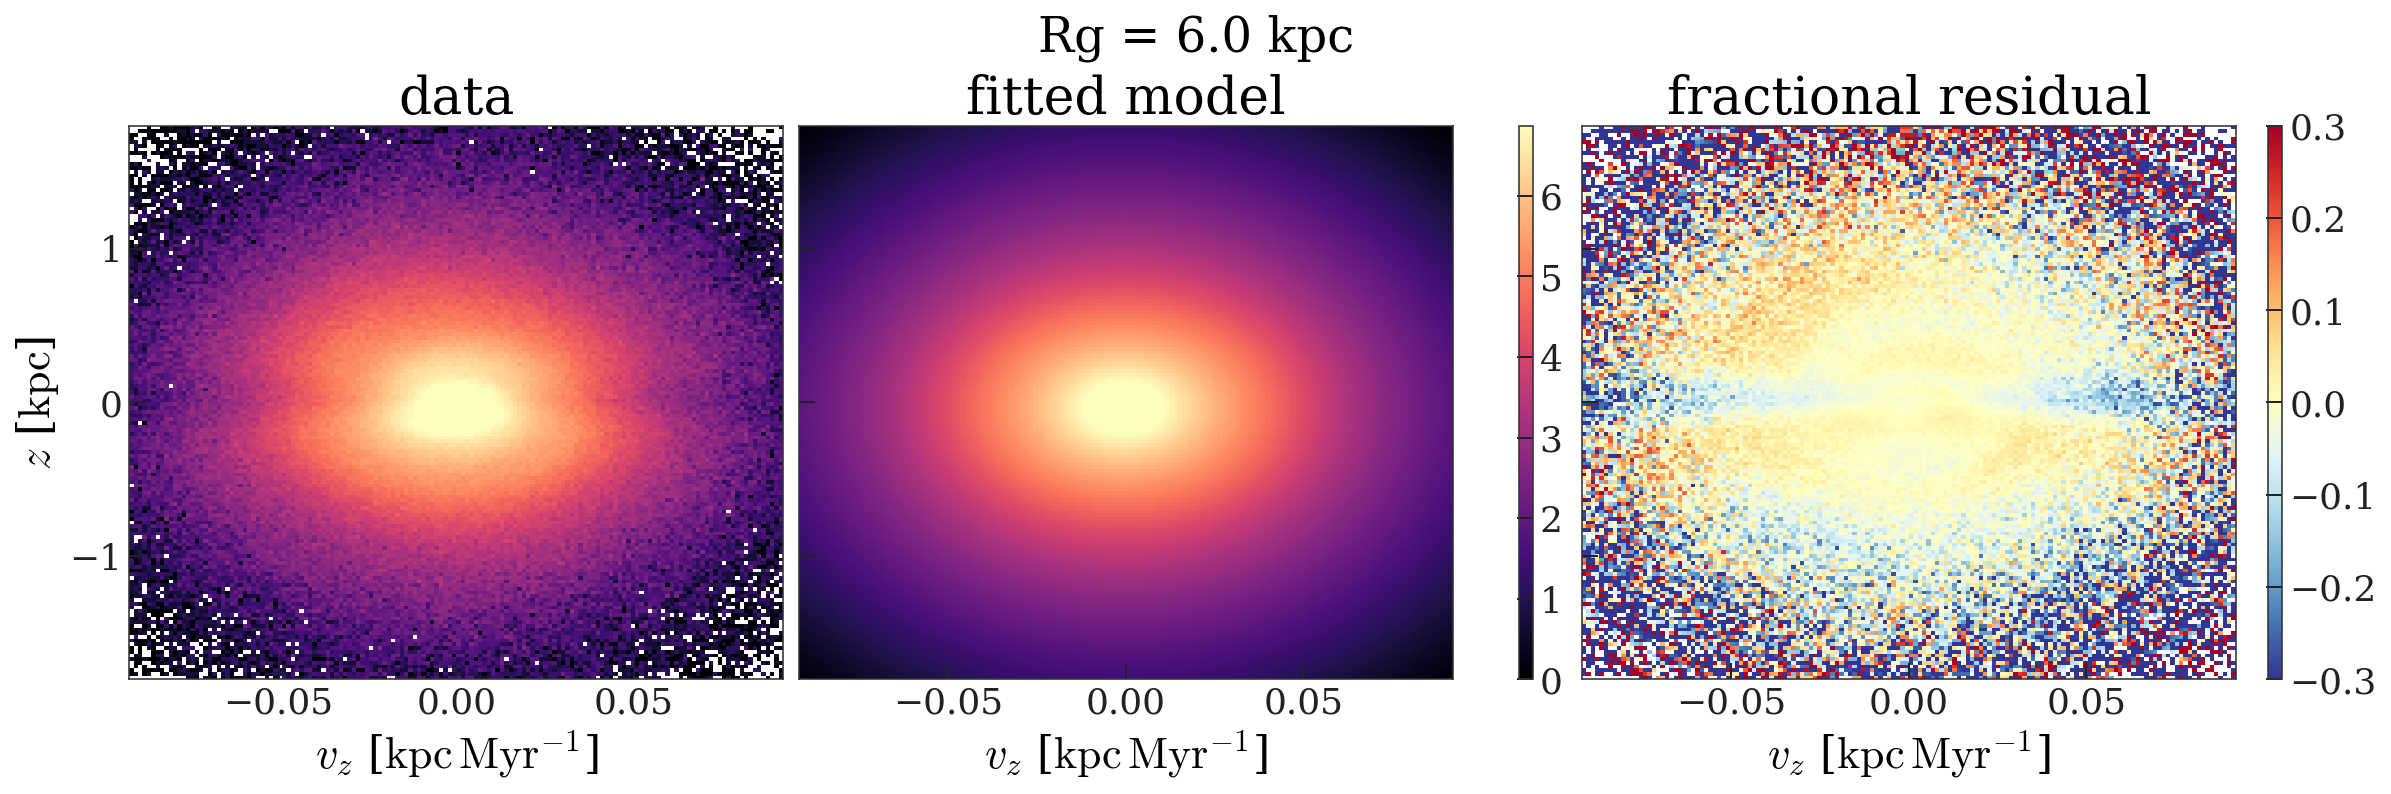

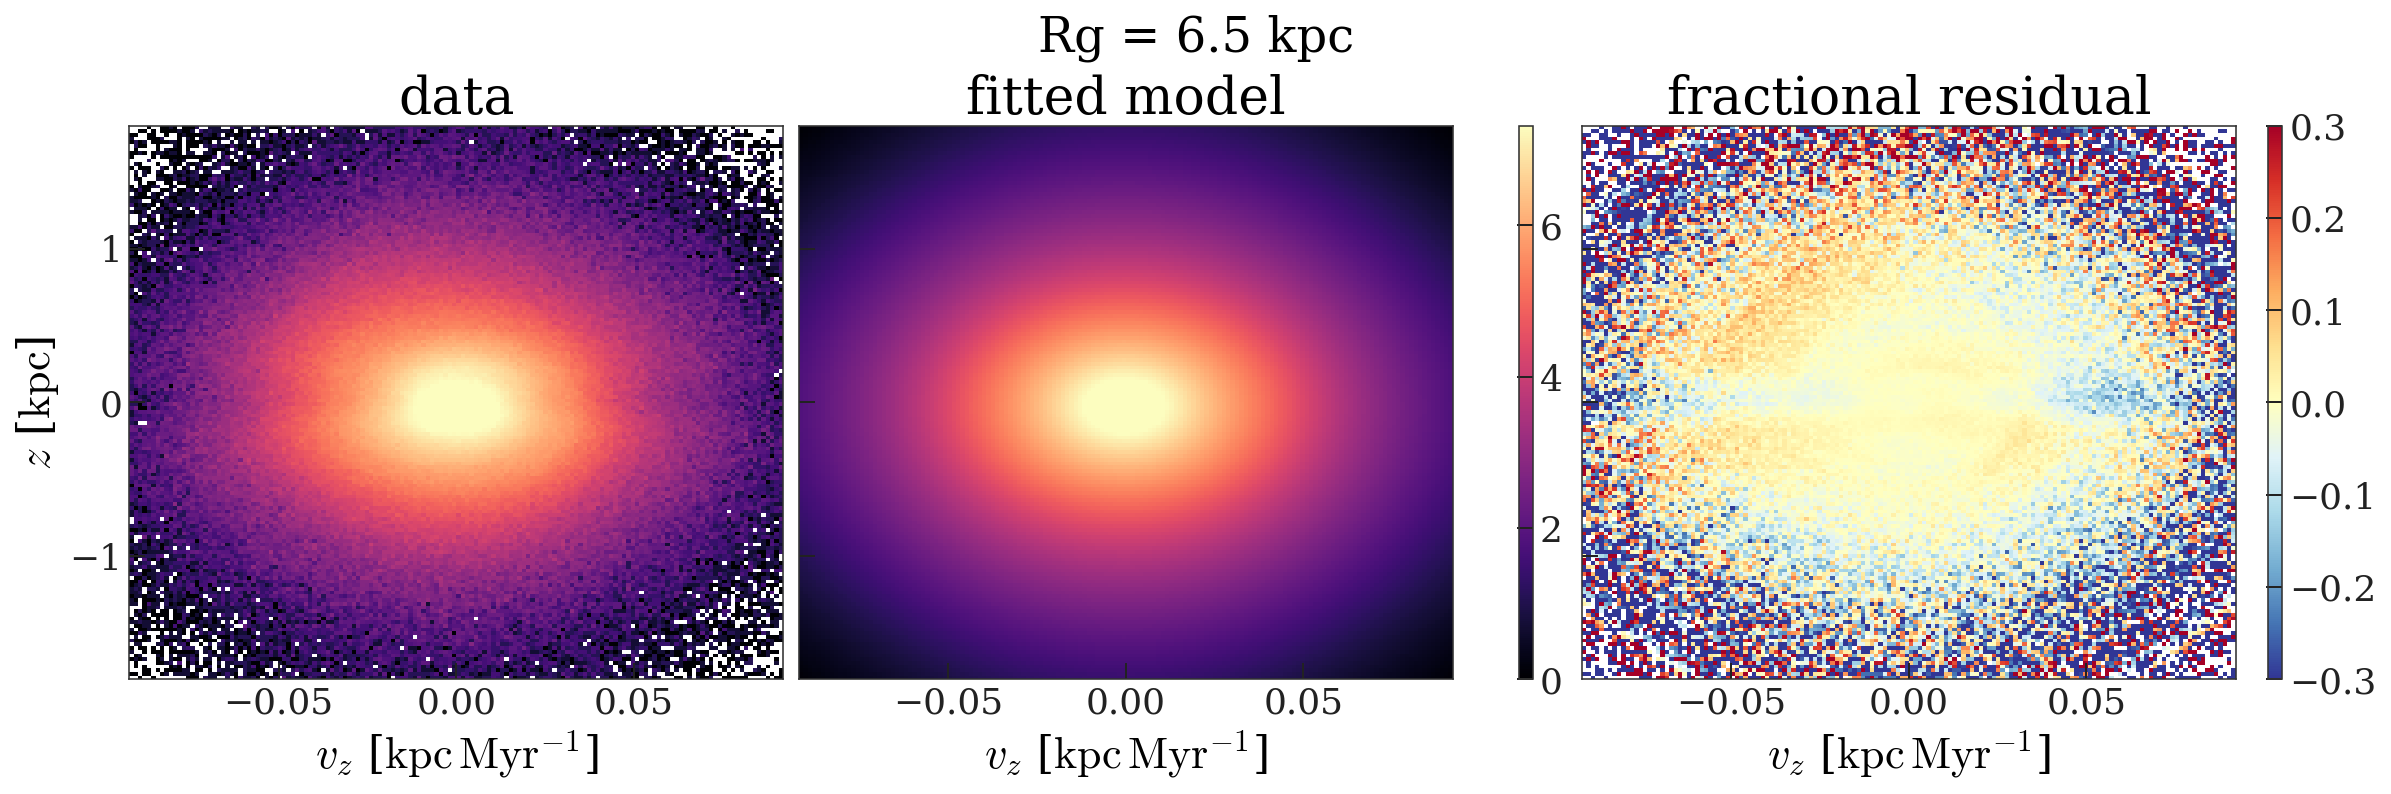

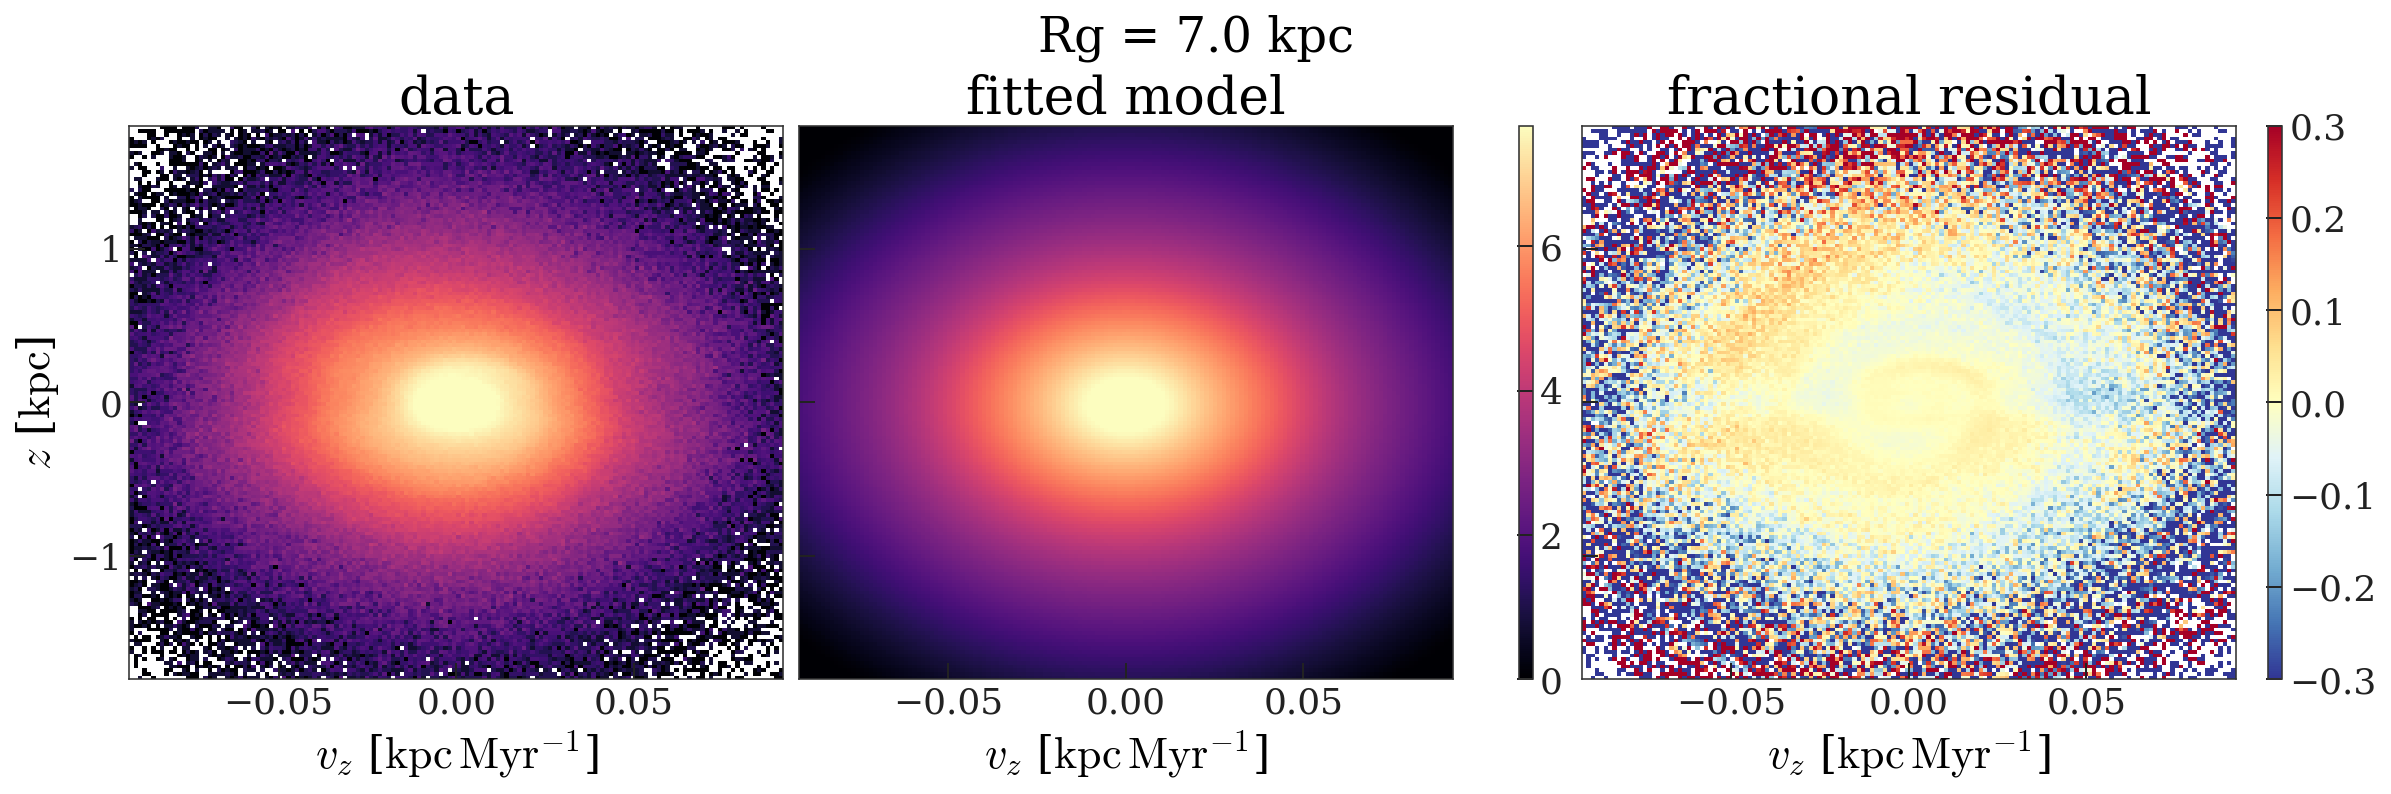

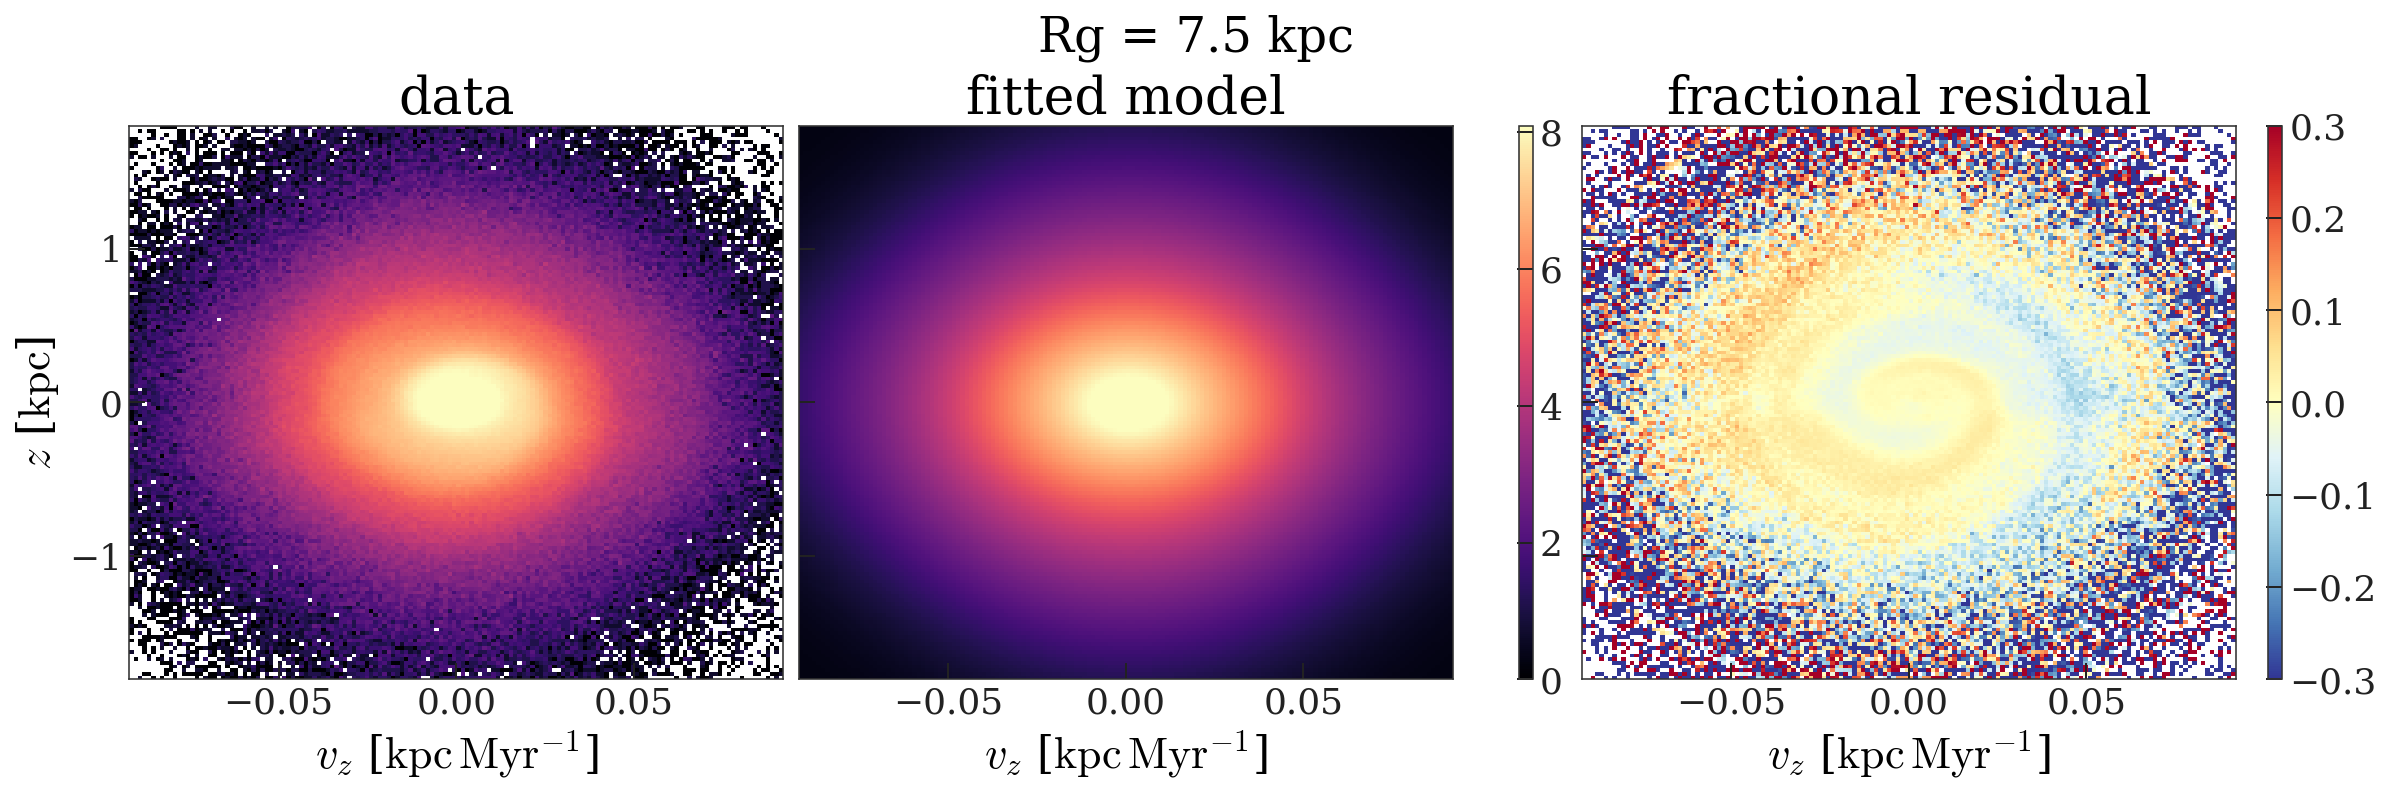

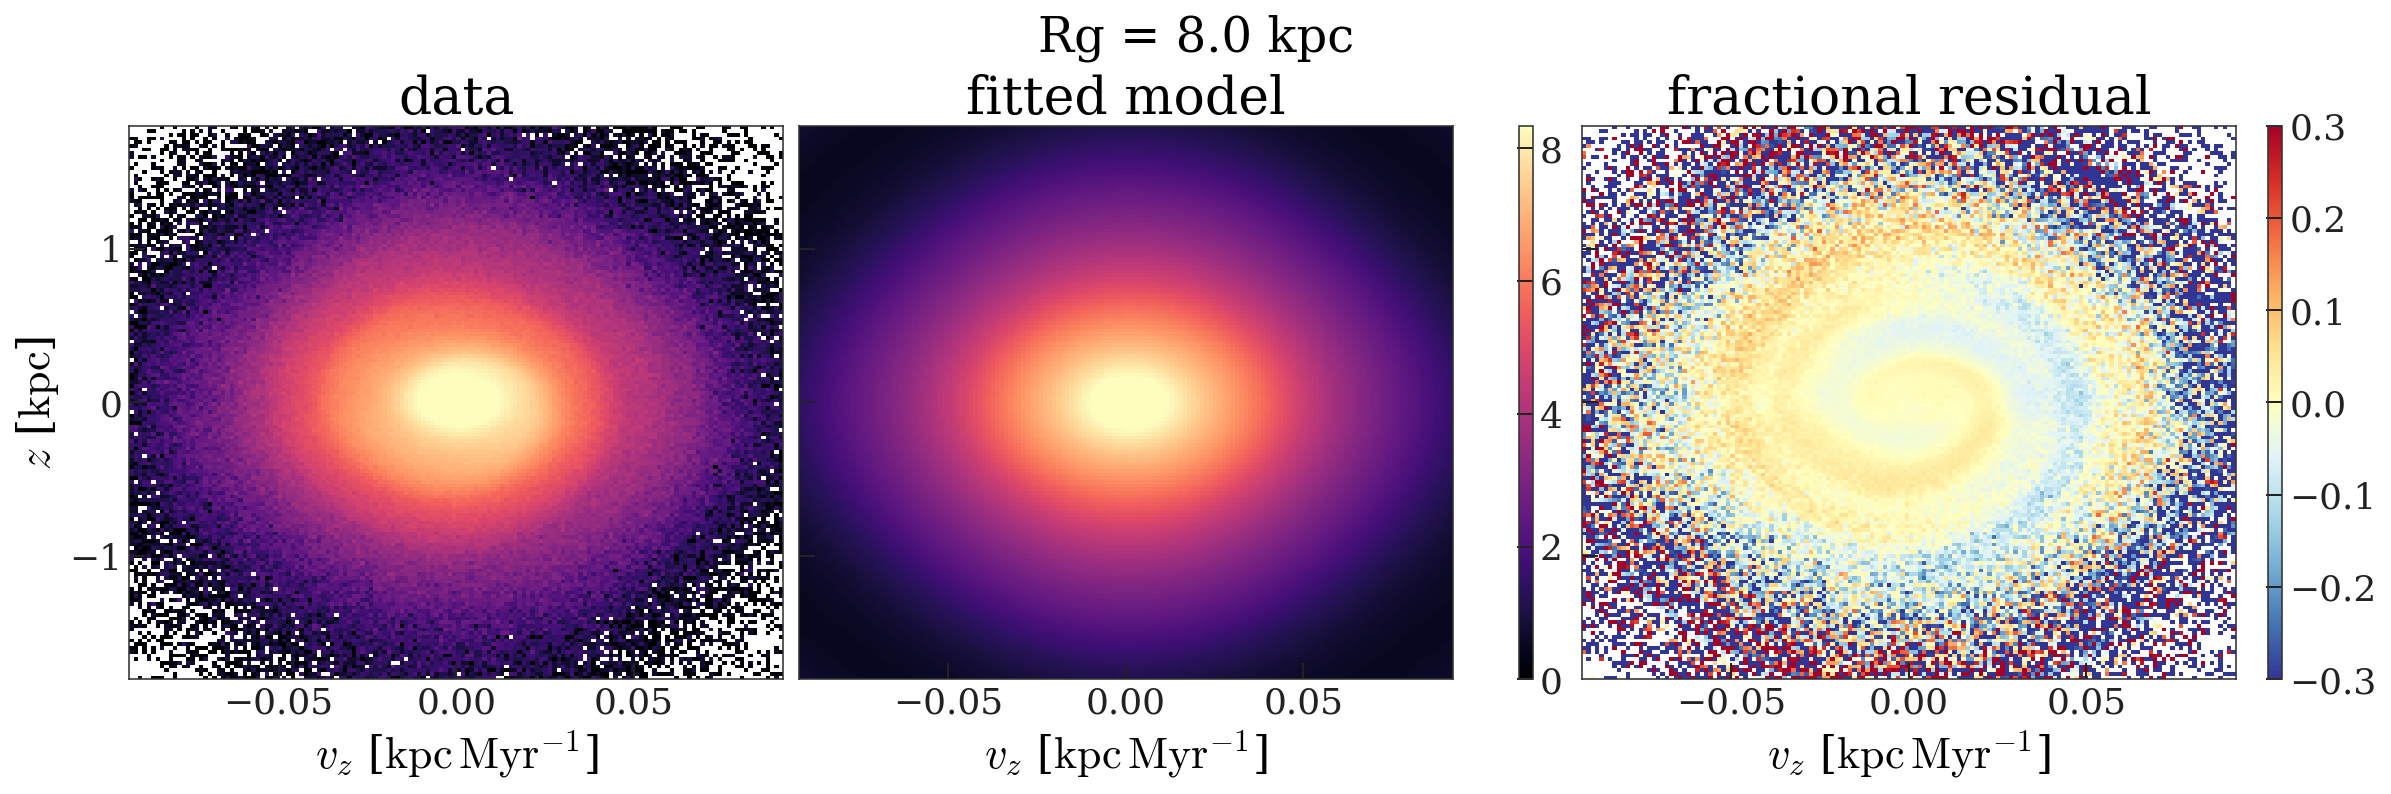

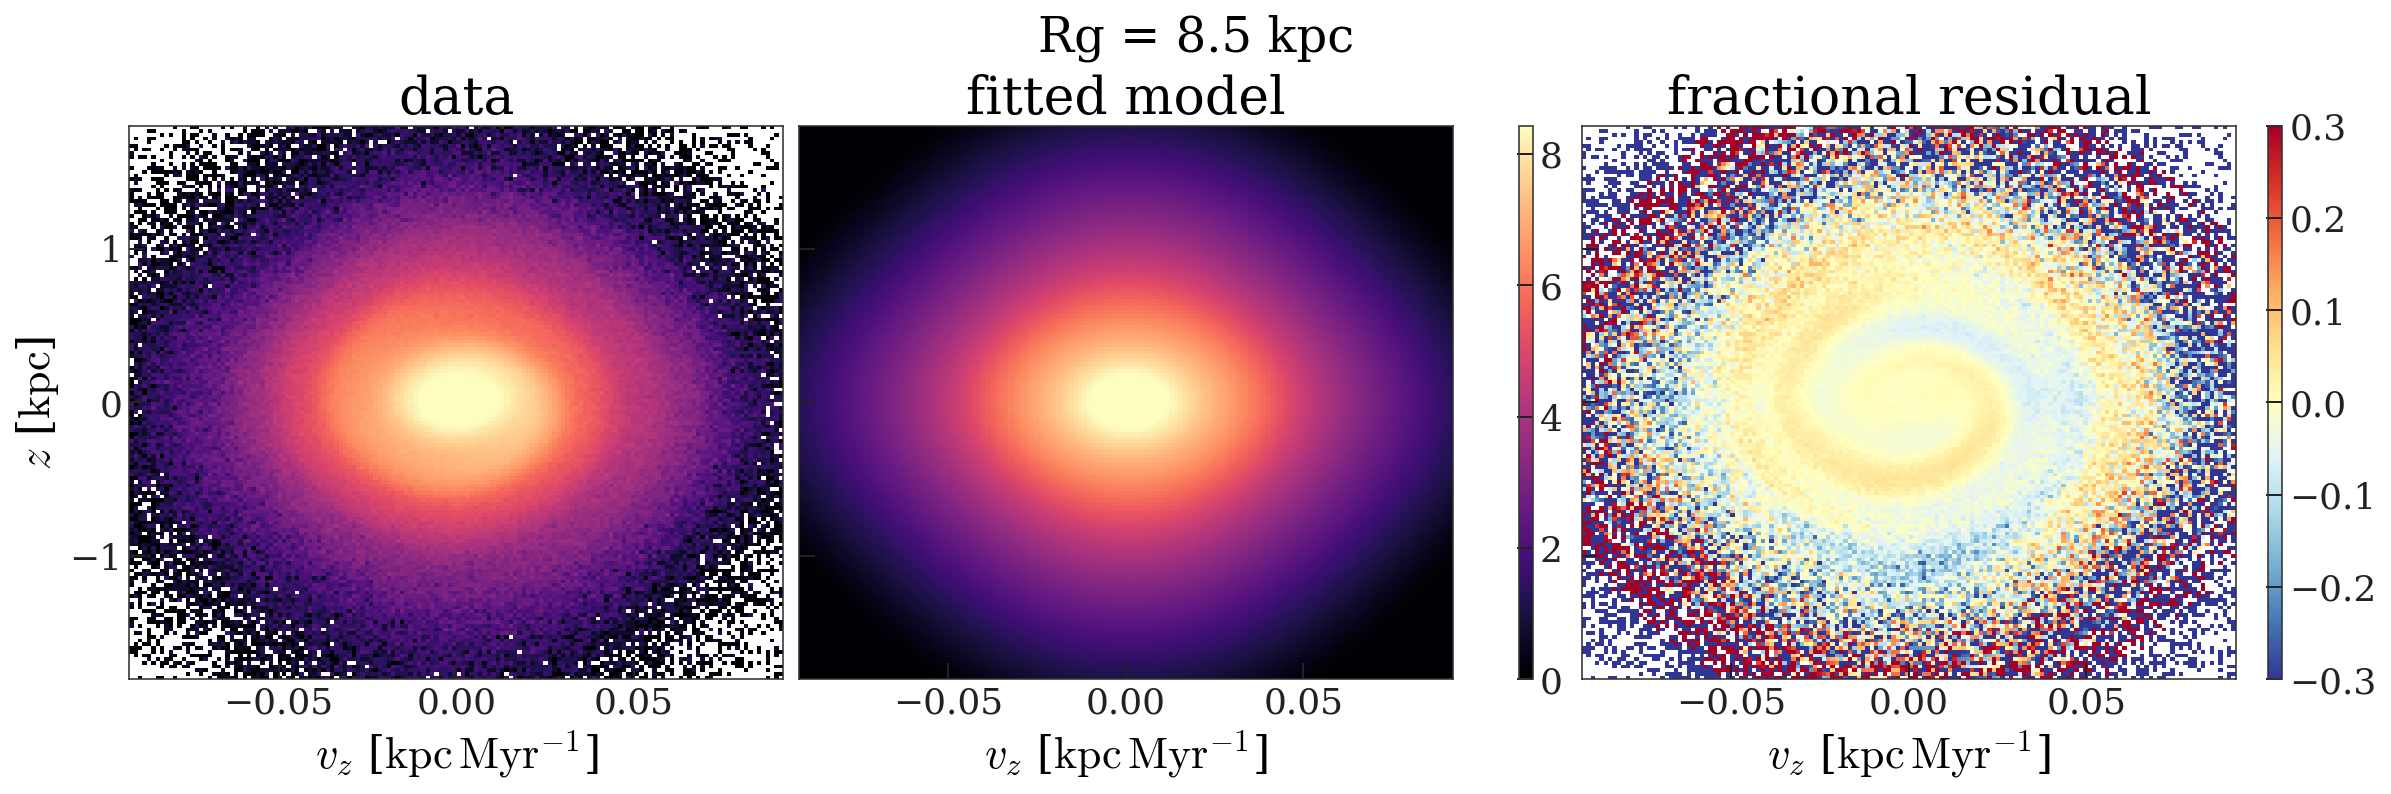

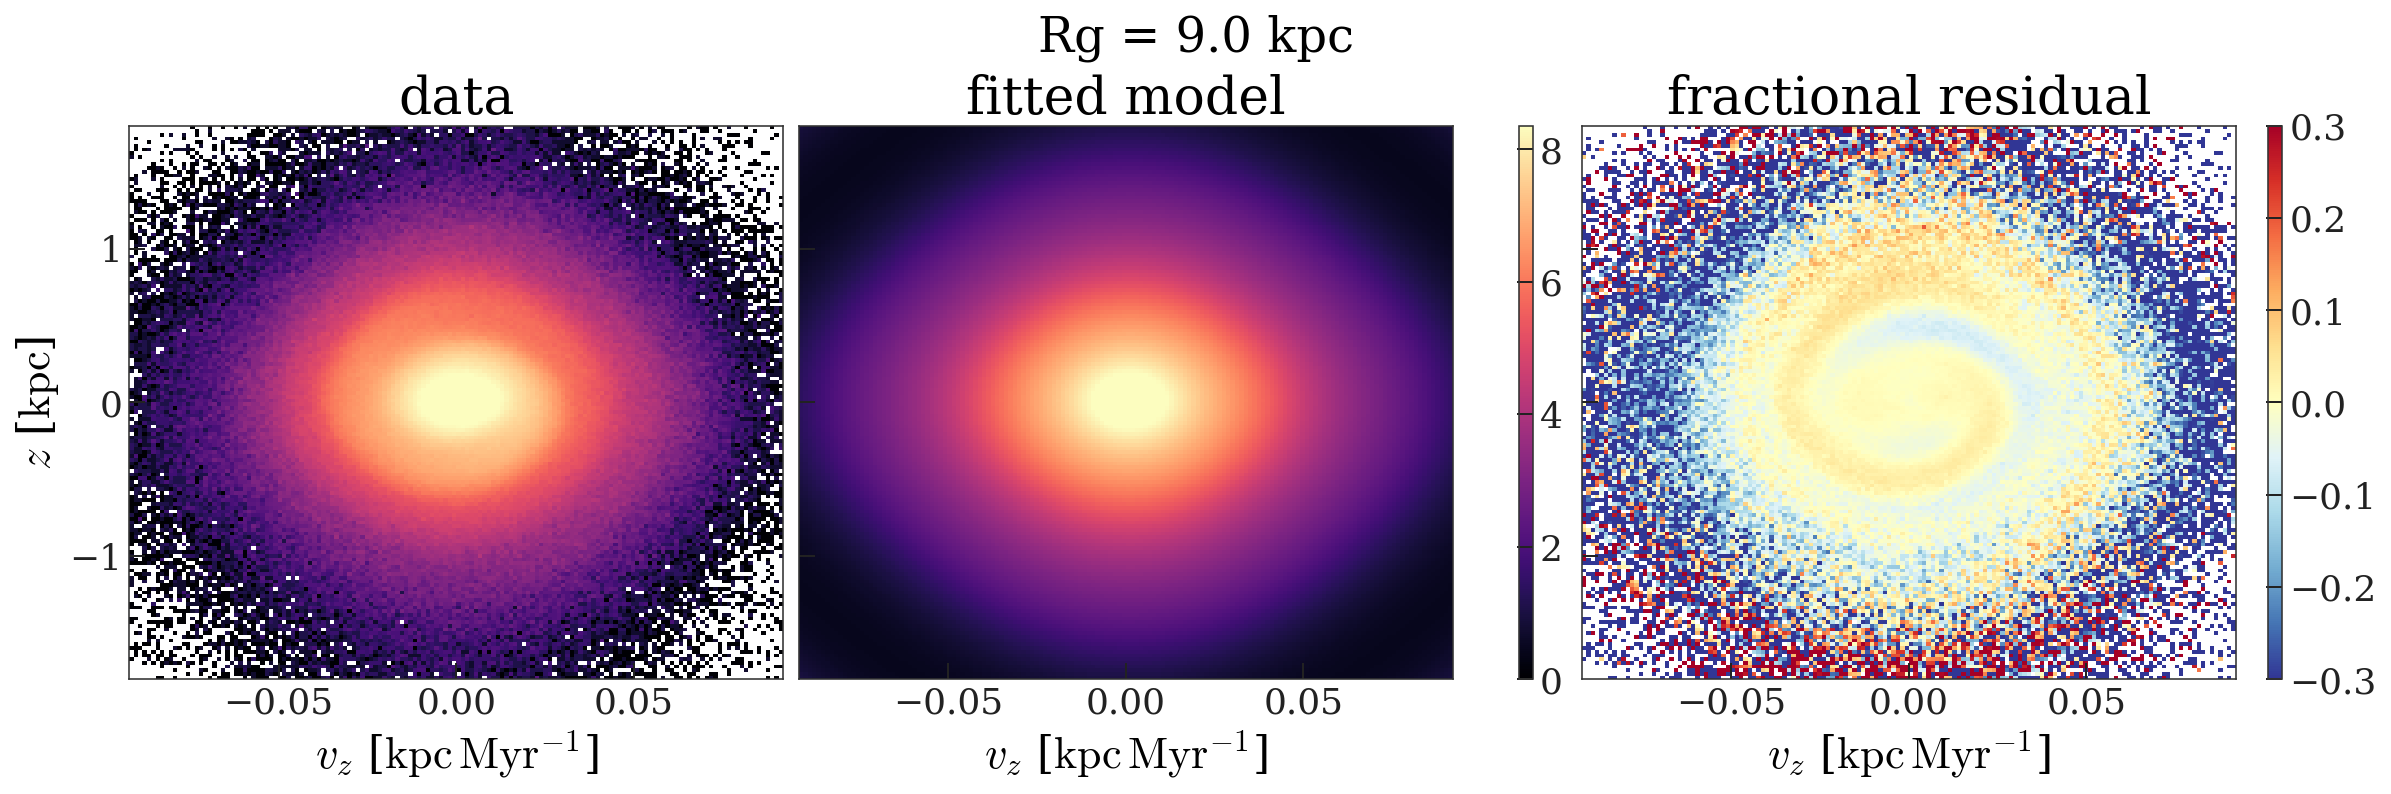

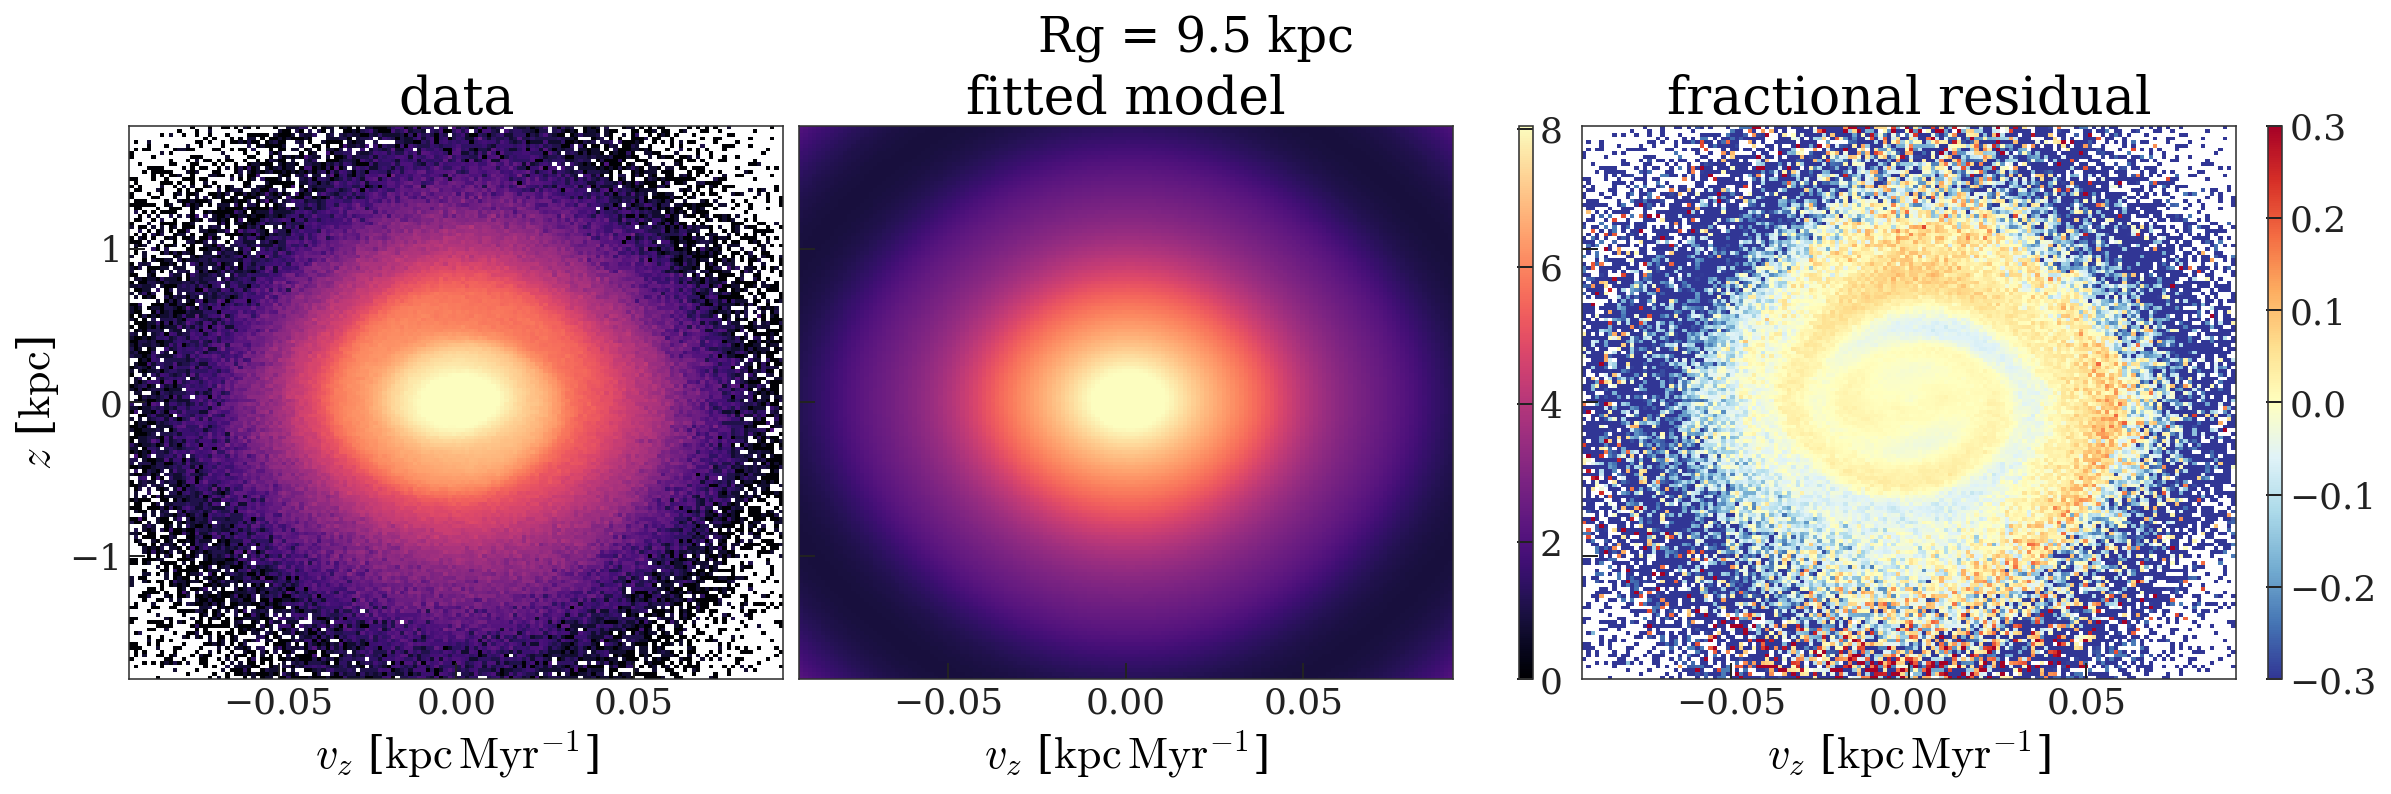

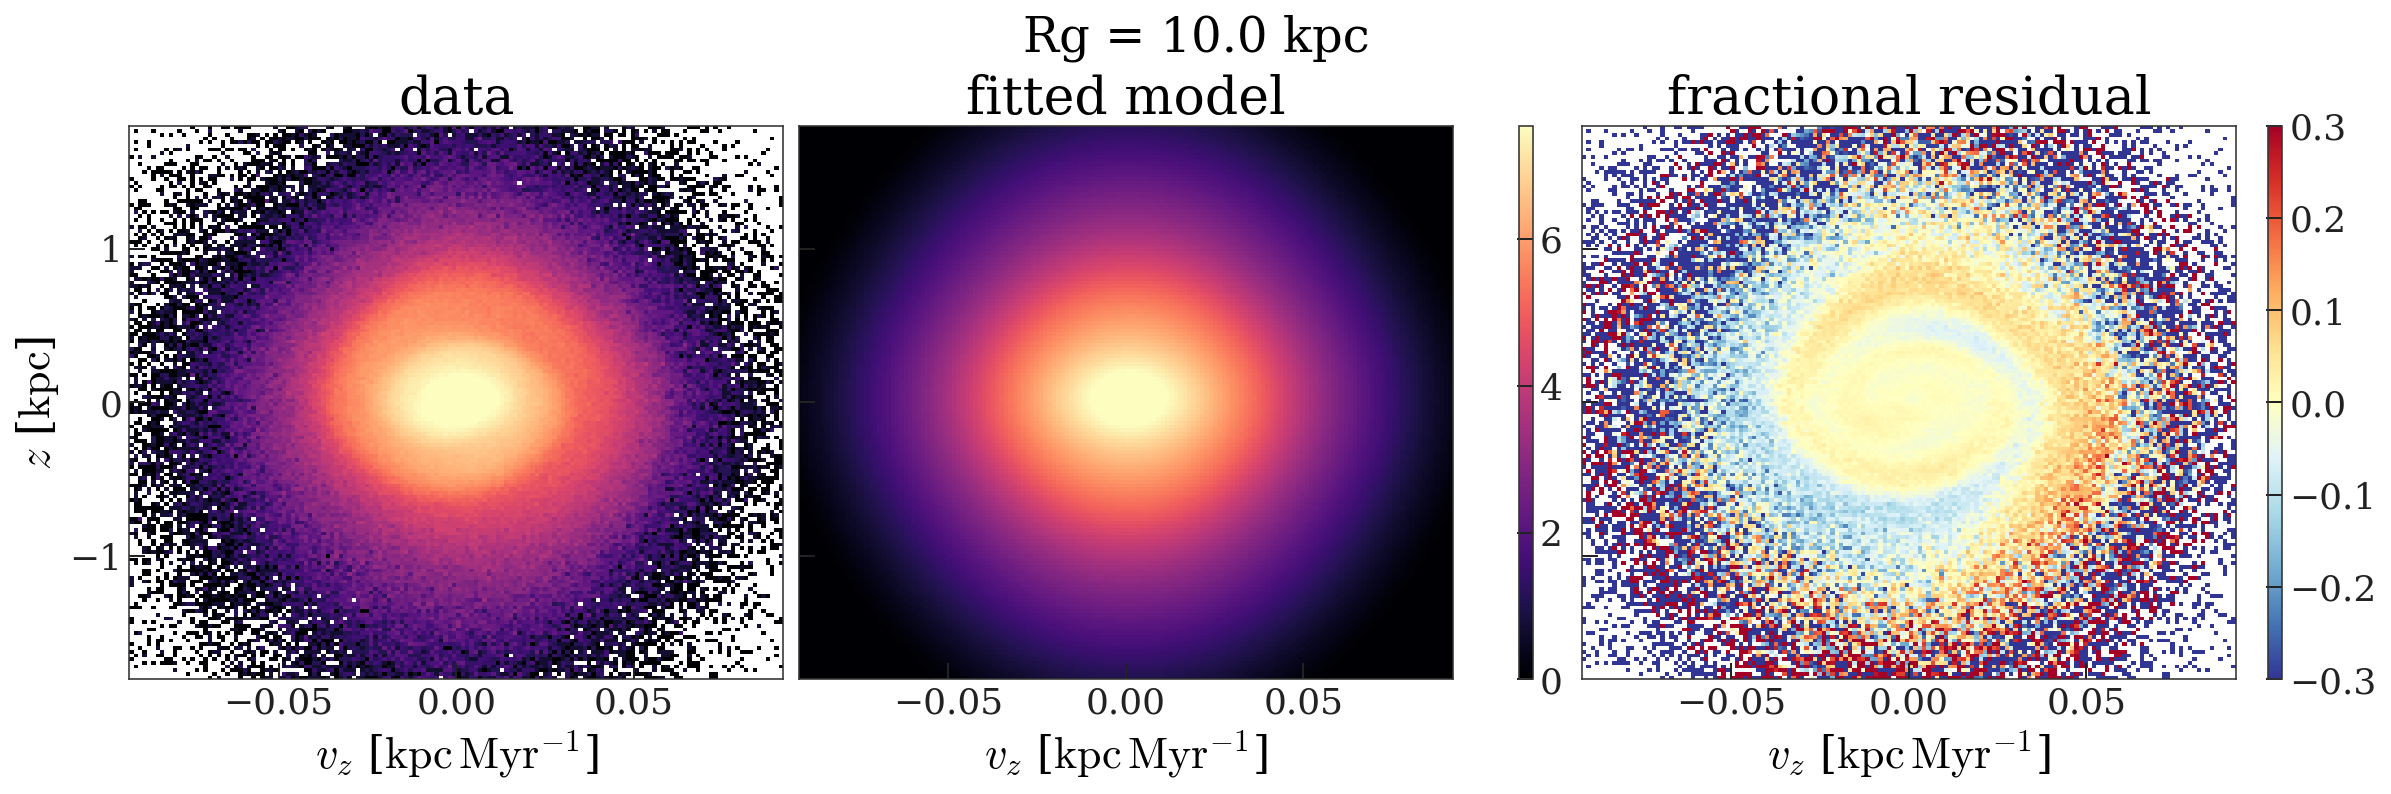

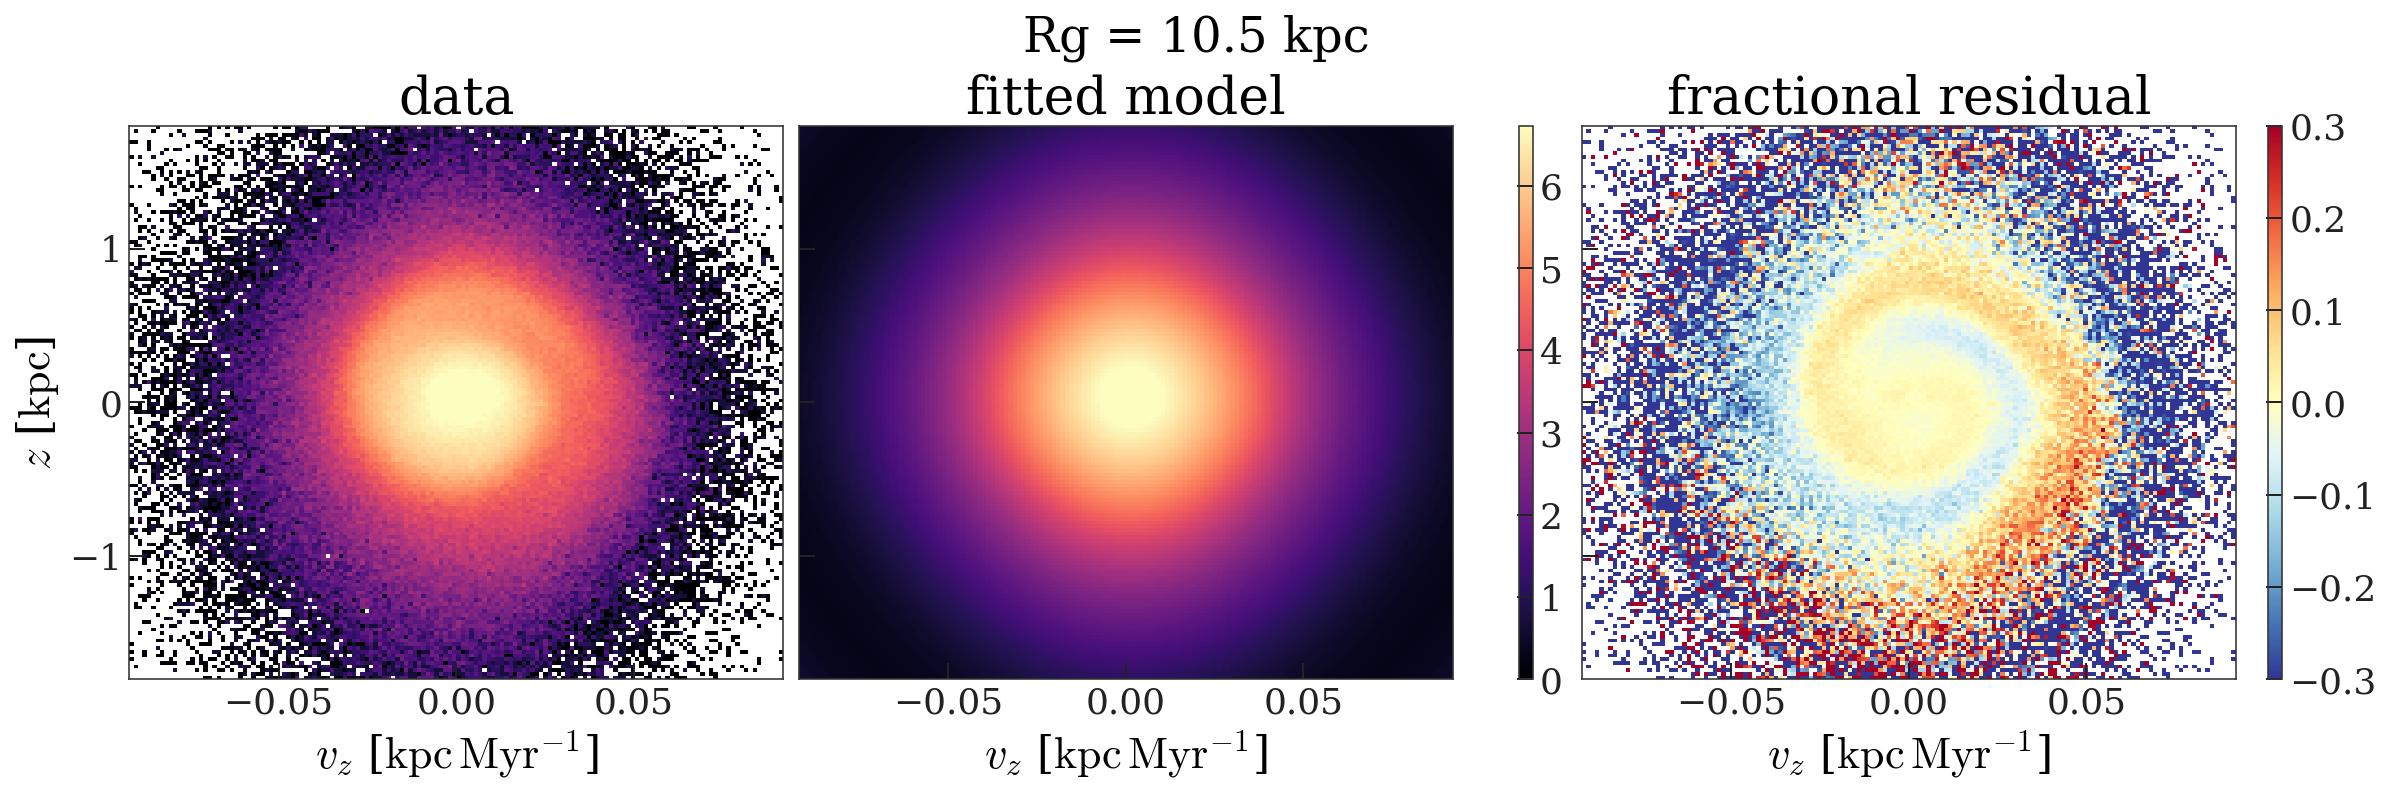

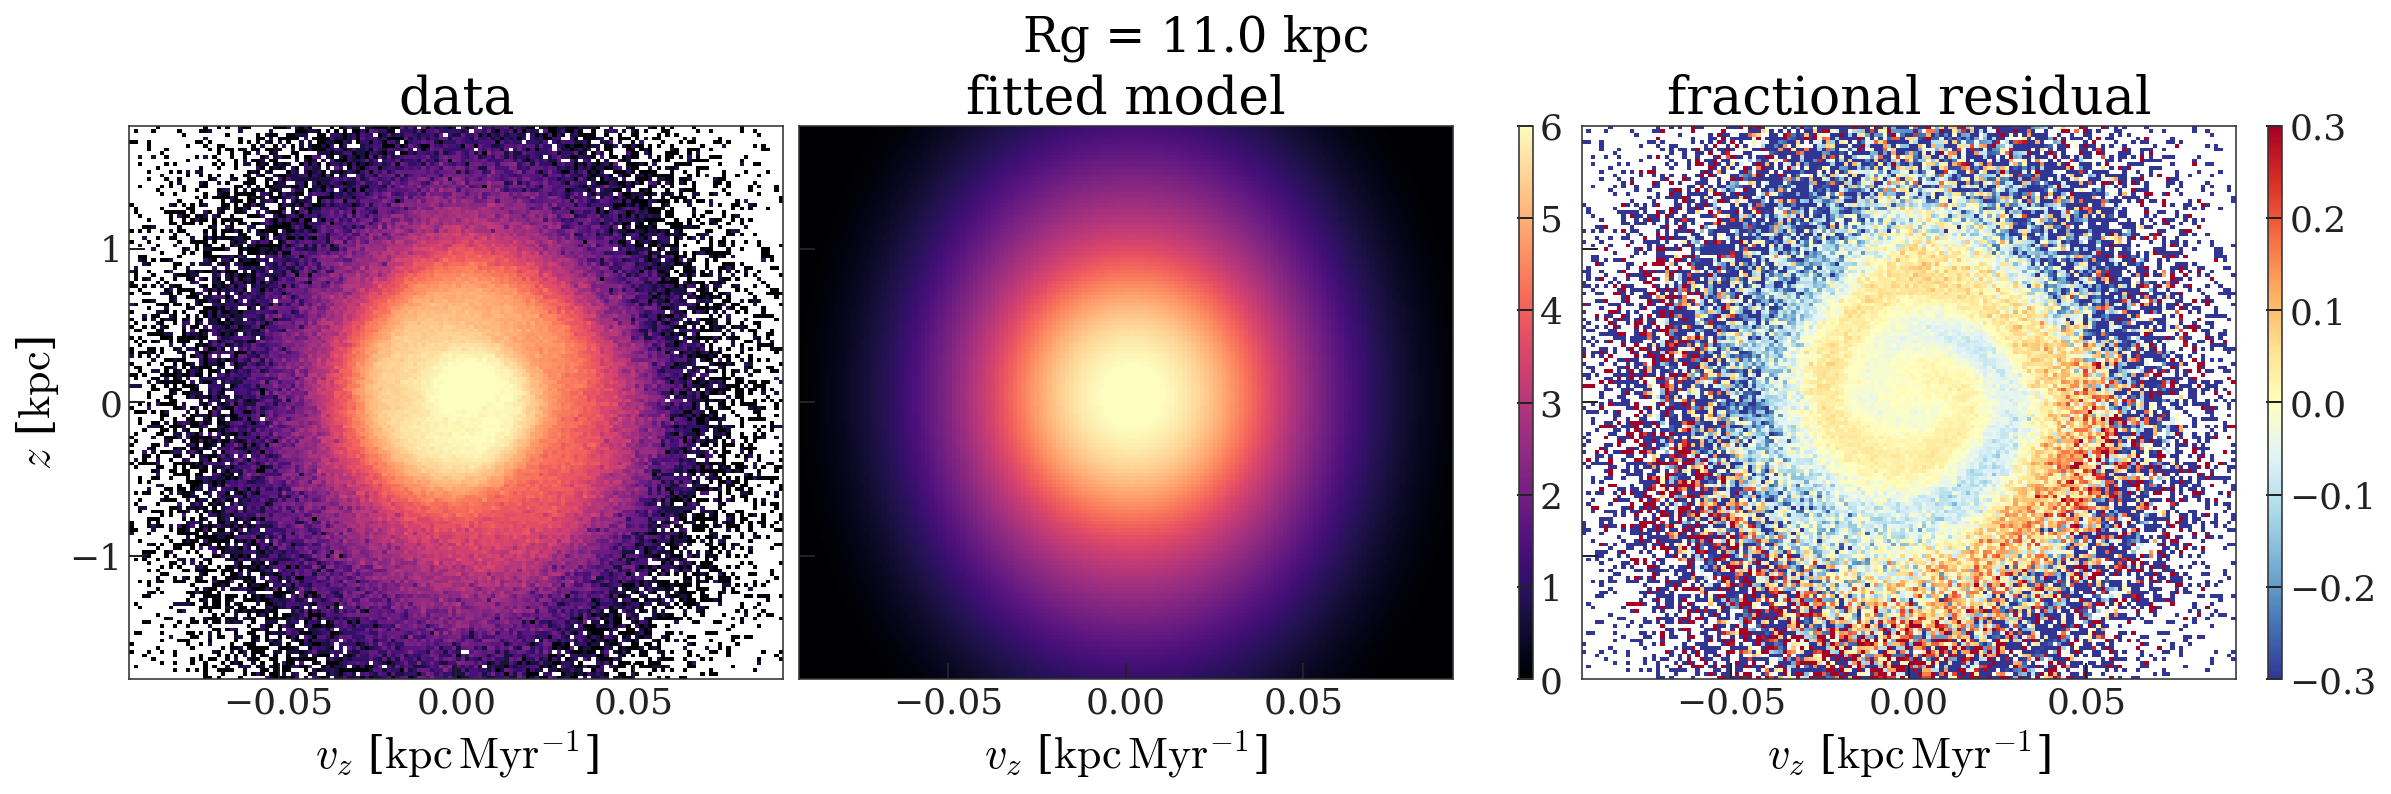

In [7]:
for i, Rg_c in enumerate(Rgs):
    model, res_params, bdata, _ = get_bin(i)

    # _ = plot_bdata(bdata)
    fig, axes = oti.plot.plot_data_models_residual(bdata, model, res_params)
    fig.suptitle(f"Rg = {Rg_c:.1f}", fontsize=24)

In [8]:
max_z = bdata["pos"].max()

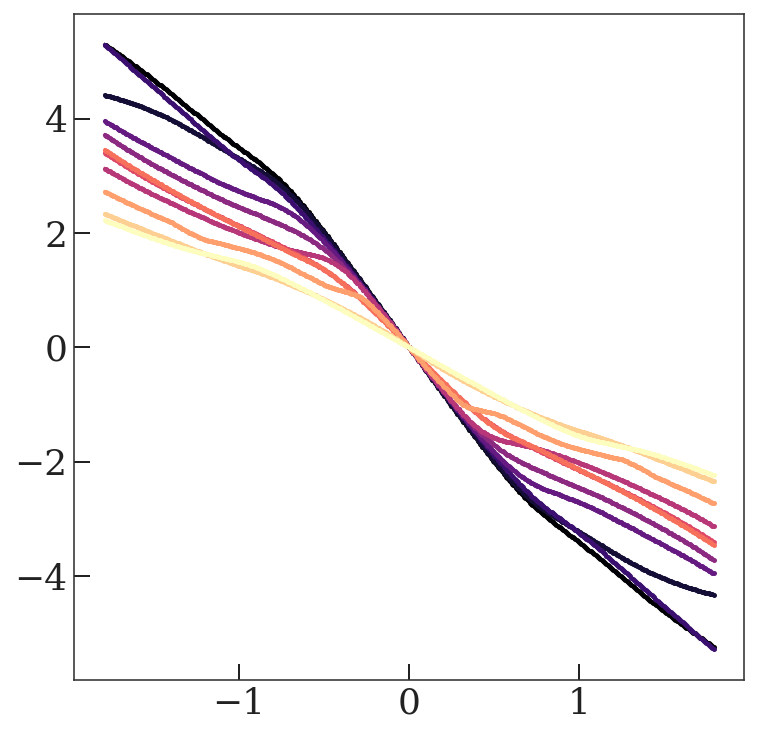

In [12]:
zgrid = np.linspace(-1, 1, 512) * max_z
a_unit = u.km / u.s / u.Myr

norm = mpl.colors.Normalize(Rgs.min().value, Rgs.max().value)
cmap = plt.get_cmap("magma")
for i, Rg_c in enumerate(Rgs):
    model, res_params, bdata, _ = get_bin(i)
    bestfit_acc = model.get_acceleration(zgrid, res_params).to(a_unit)
    plt.plot(zgrid, bestfit_acc.value, color=cmap(norm(Rg_c.value)))

In [10]:
rng = np.random.default_rng(42)
all_aafs = []
for i, Rg_c in enumerate(Rgs):
    print(i)
    model, res_params, _, pdata = get_bin(i)

    subset_N = np.sort(
        rng.choice(len(pdata), size=min(len(pdata), 100_000), replace=False)
    )
    all_aafs.append(
        model.compute_action_angle(
            pdata["z"][subset_N], pdata["v_z"][subset_N], res_params, N_grid=11
        )
    )

0
1
2
3
4
5
6
7
8
9
10


<Quantity [0.36179804, 0.1544662 , 0.38264809, ..., 0.54702142, 0.29759296,
           1.19163815] kpc / rad(1/2)>

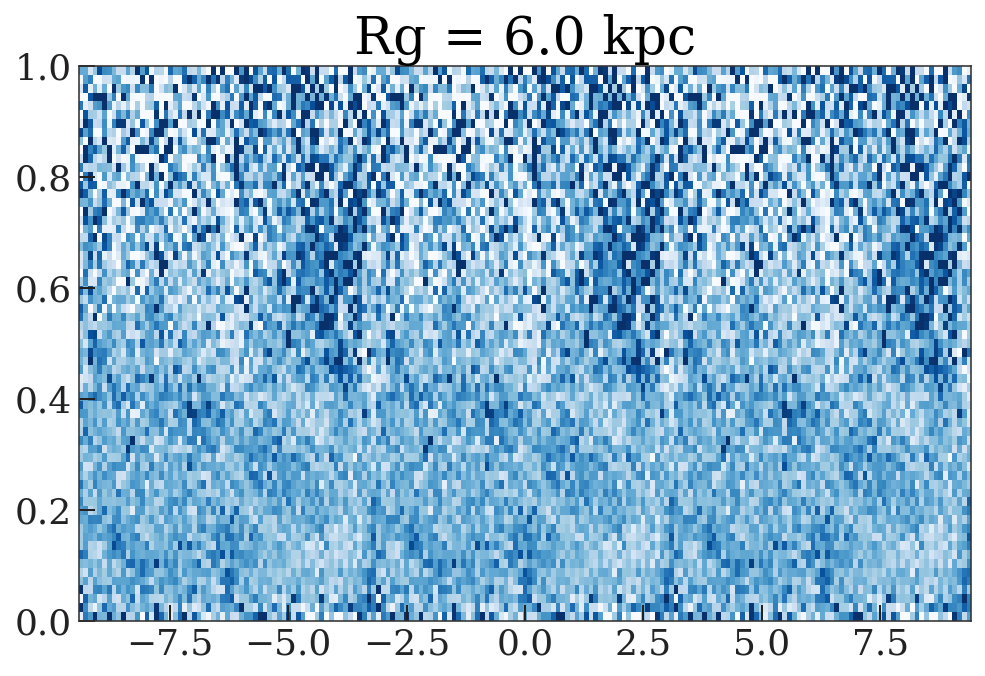

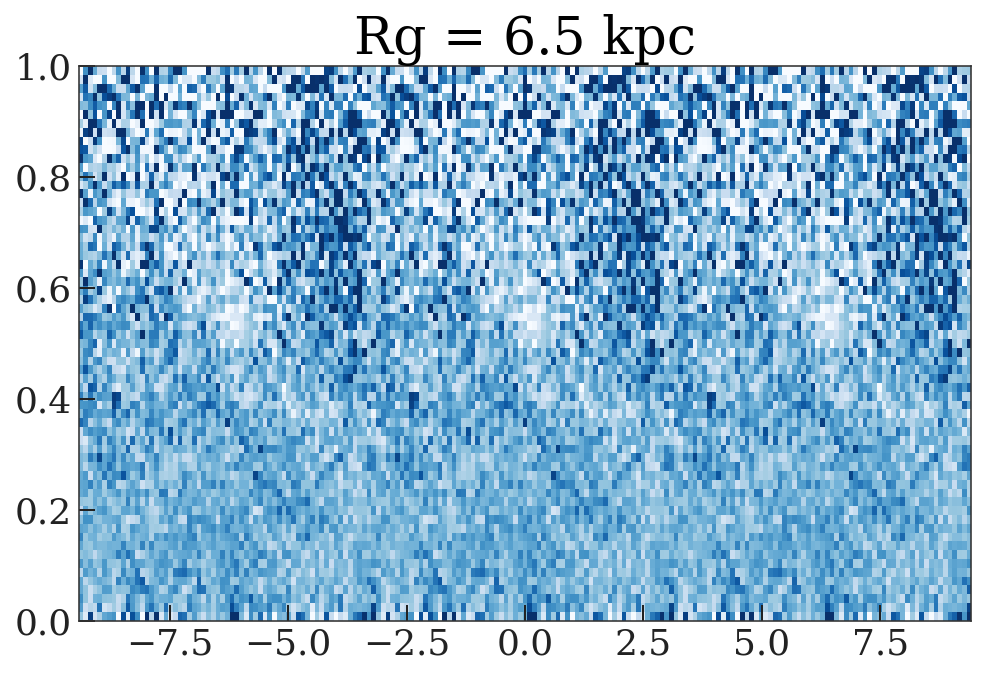

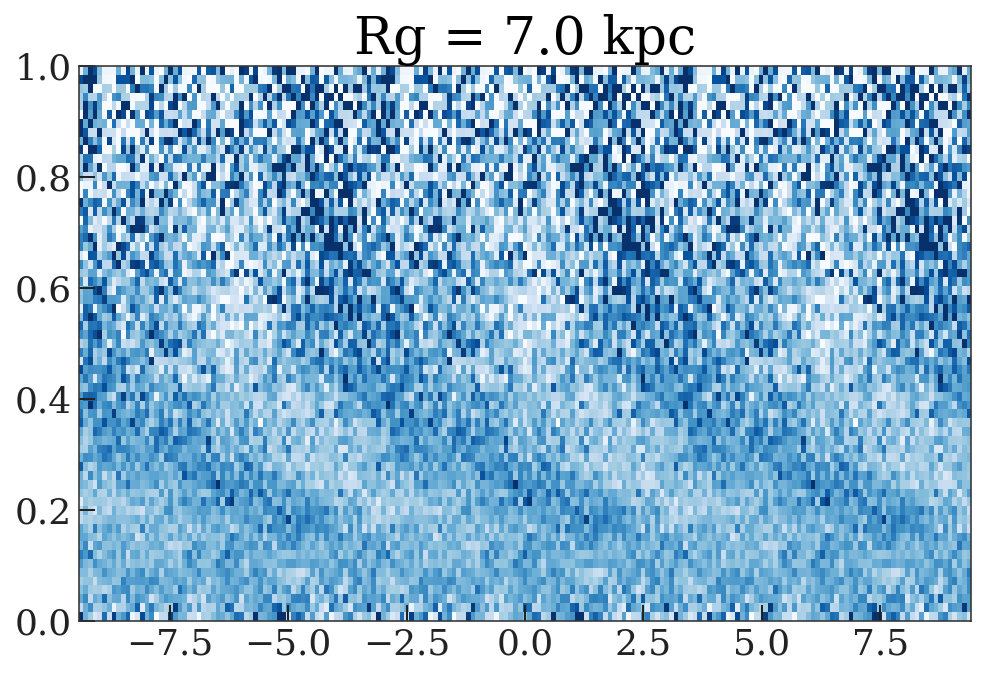

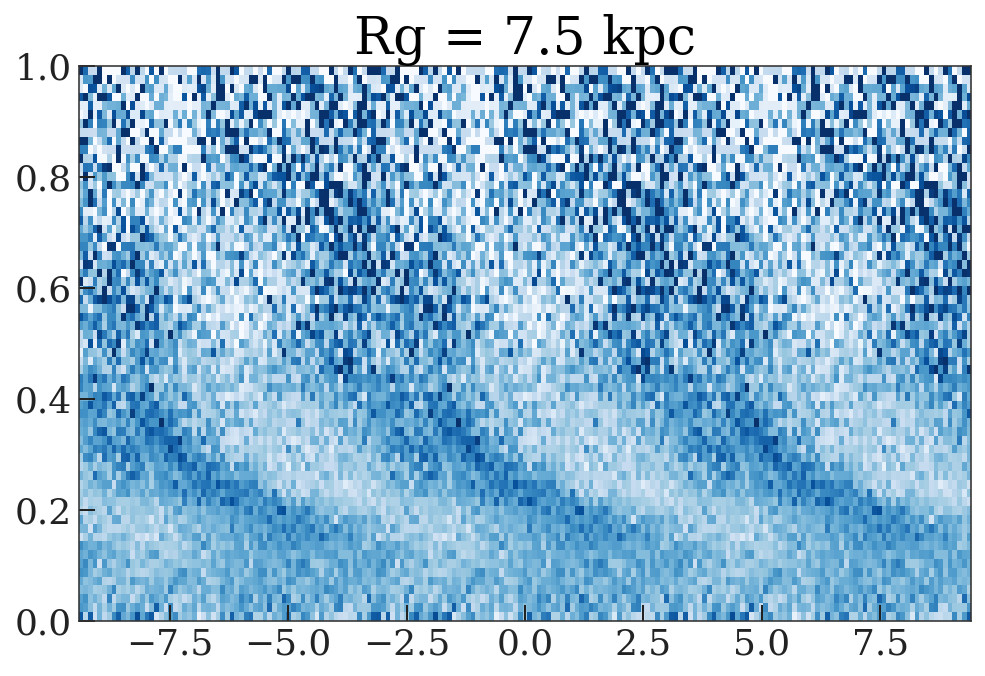

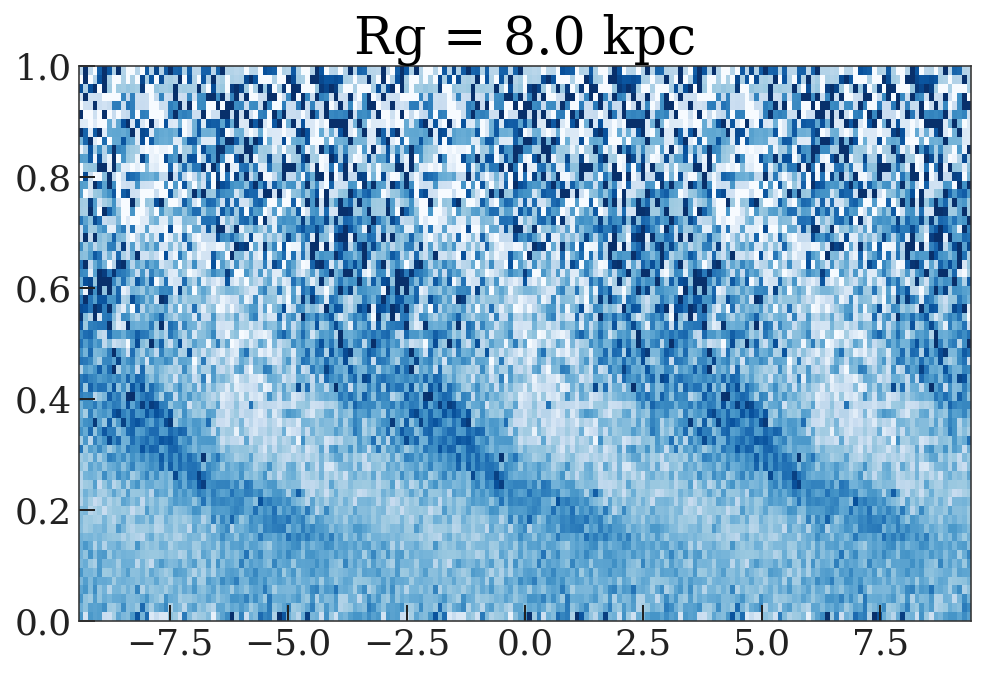

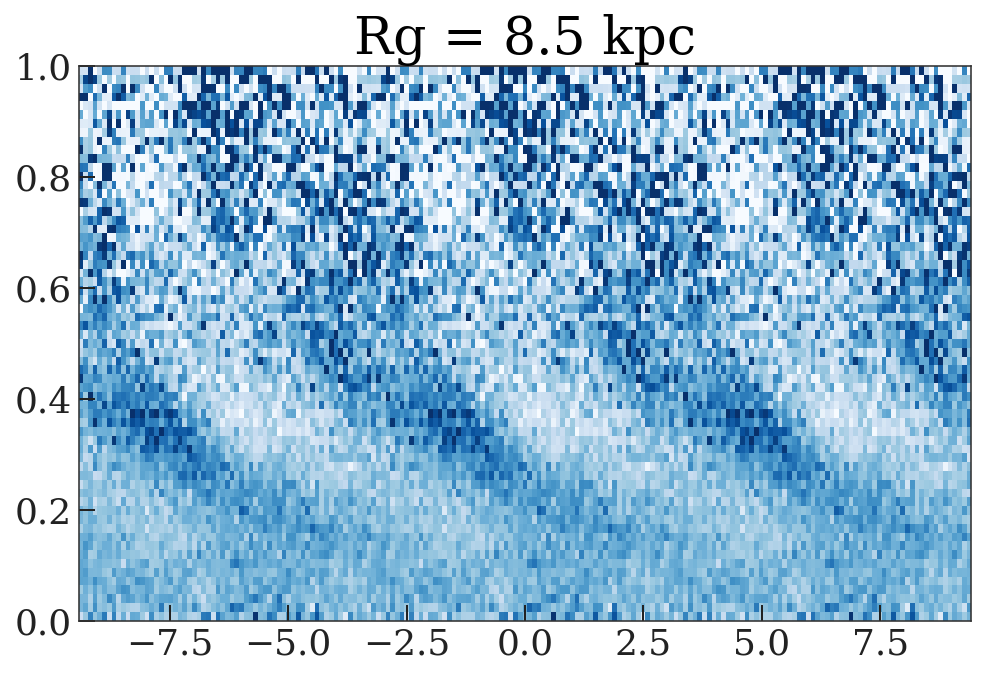

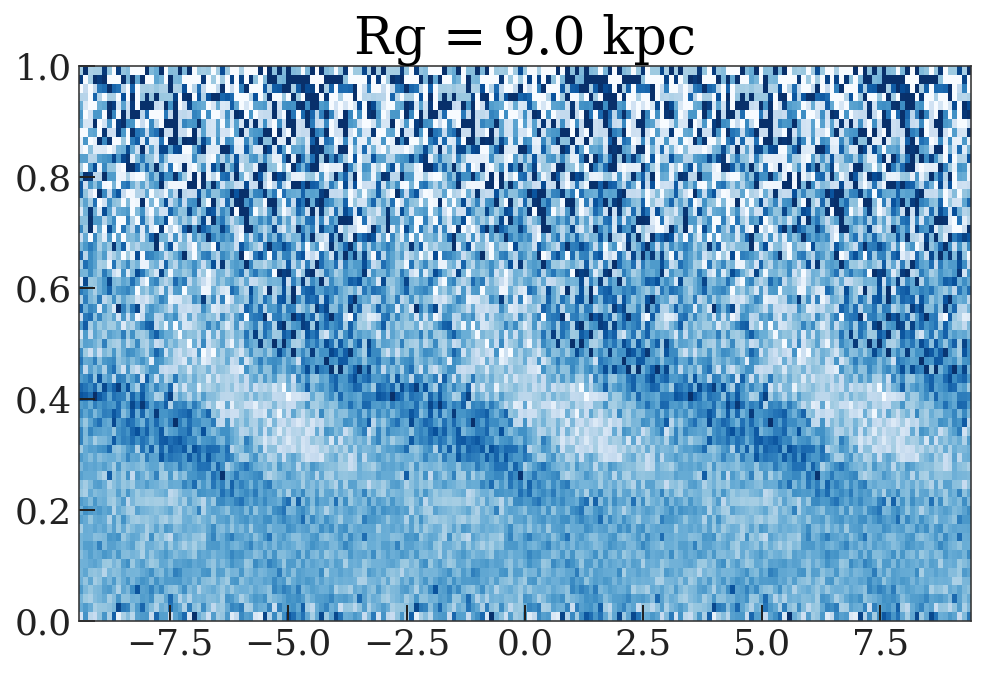

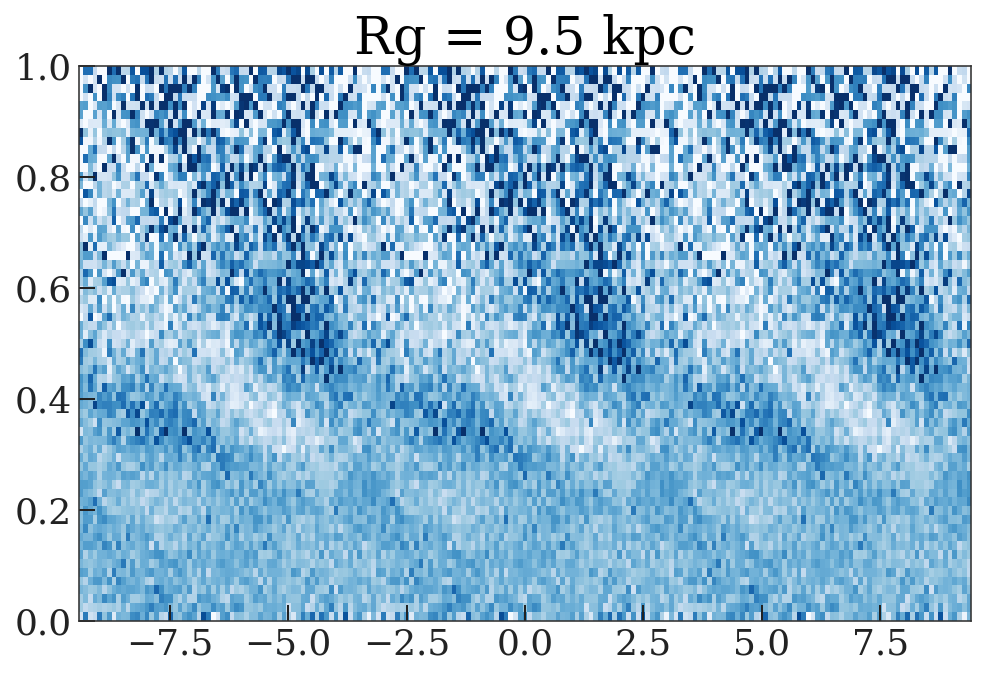

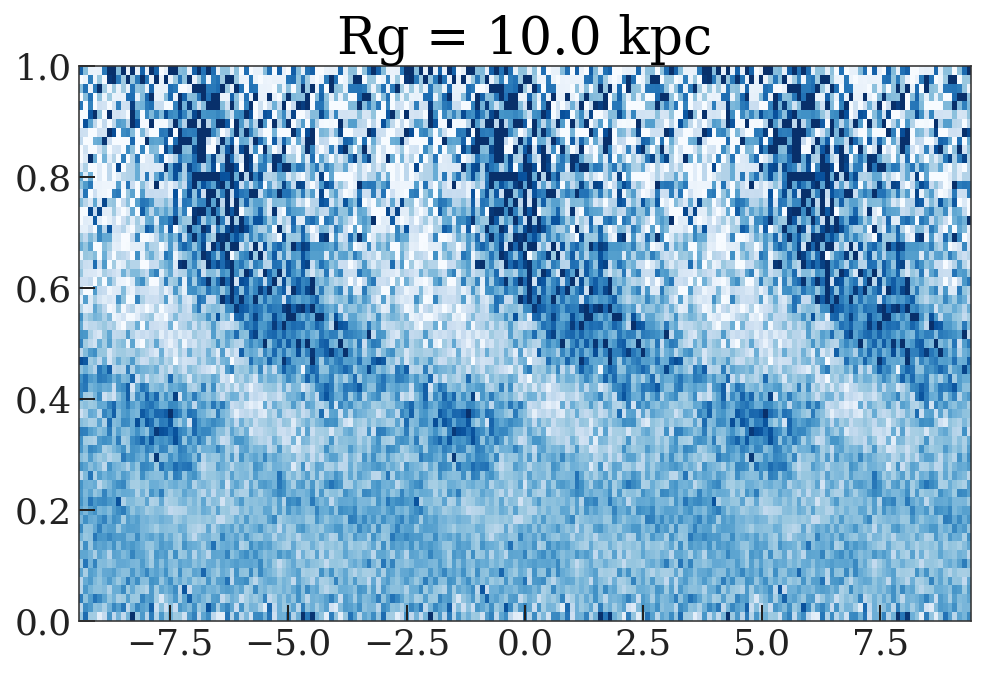

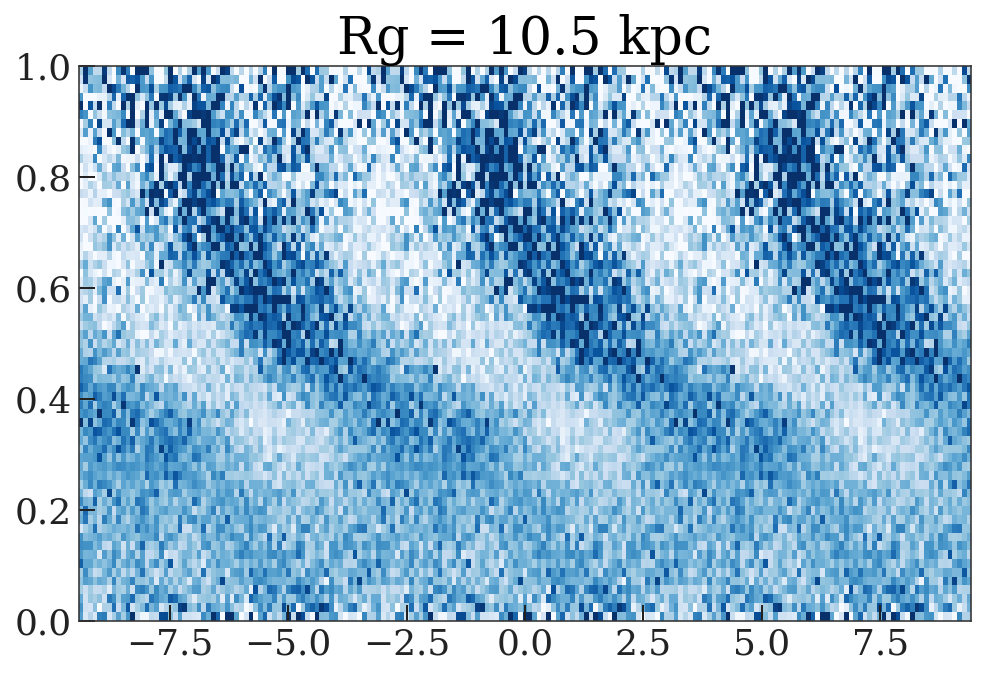

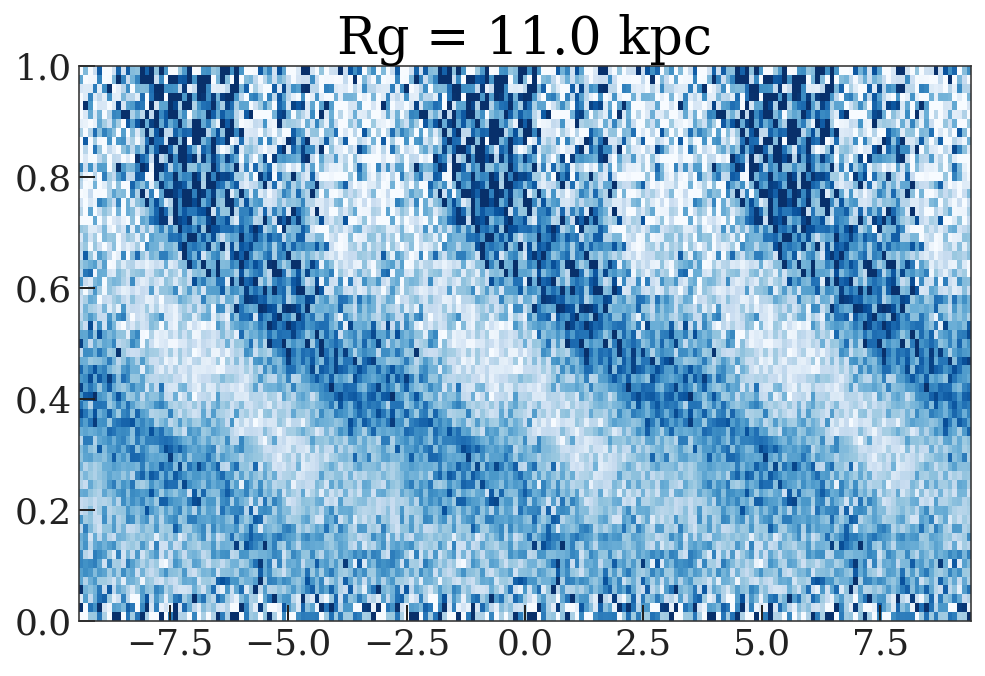

In [31]:
for i, Rg_c in enumerate(Rgs):
    aaf = all_aafs[i]

    zmax = np.sqrt(aaf["J"] / aaf["Omega"]).decompose(galactic).value
    H, xe, ye = np.histogram2d(
        aaf["theta"].to_value(u.rad),
        # np.sqrt(aaf['J'].to_value(u.kpc*u.km/u.s)),
        # bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 5, 64))
        zmax,
        bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 1.0, 64)),
    )

    dH = H.T / H.T.sum(axis=0)[None]
    dH = (dH - dH.mean(axis=1)[:, None]) / dH.mean(axis=1)[:, None]
    vmin, vmax = np.nanpercentile(dH, [5, 95])
    kw = dict(cmap="Blues", vmin=vmin, vmax=vmax)

    plt.figure(figsize=(8, 5))
    plt.pcolormesh(xe - 2 * np.pi, ye, dH, **kw)
    plt.pcolormesh(xe, ye, dH, **kw)
    plt.pcolormesh(xe + 2 * np.pi, ye, dH, **kw)
    plt.title(f"Rg = {Rg_c:.1f}")

TODO: make summary plot of panels of residuals for spiral, zebra plots, acceleration profiles
Add lines of constant time (slope) to zebra plots, make them Omega vs. theta